<a href="https://colab.research.google.com/github/DhrumilPrajapati03/Segmentation_model_using_U-net/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to c:\users\user\appdata\local\temp\pip-req-build-a32y4qok
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models 'C:\Users\user\AppData\Local\Temp\pip-req-build-a32y4qok'
  Running command git submodule update --init --recursive -q

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#### [CONFIG] ####

# model training

epochs = 30

# dataset

tile_size = 64
#overlap = 0
overlap = 32

filter_enough_change = True
#change_pix_percent = 0.0 # has at least some change
#change_pix_percent = 0.1 # has at least 10% change (only 336 samples!)
change_pix_percent = 0.03 # has at least 3% change (1044 samples - might be actually good!)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math
import sklearn.metrics
# all ch loading:
import shutil
from glob import glob
from skimage import io

from tqdm import tqdm
from pprint import pprint

In [ ]:
img_dir = "D:/DATASETS/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images"
test_dir = "D:/DATASETS/OSCD_DATASET/Onera Satellite Change Detection dataset - Test Labels/Onera Satellite Change Detection dataset - Test Labels"
train_dir = "D:/DATASETS/OSCD_DATASET/Onera Satellite Change Detection dataset - Train Labels/Onera Satellite Change Detection dataset - Train Labels"

In [ ]:
train_cities = [name for name in os.listdir(train_dir) if os.path.isdir(train_dir+"/"+name)]
test_cities = [name for name in os.listdir(test_dir) if os.path.isdir(test_dir+"/"+name)]
print("train cities:", len(train_cities), "test cities:", len(test_cities))

train cities: 14 test cities: 10


In [ ]:
def has_change(lab):
    num_ones = np.count_nonzero(lab.flatten() == 1.0)
    num_all_pixels = len(lab.flatten())
    perc_change = num_ones / num_all_pixels

    return perc_change > change_pix_percent
    #return np.max(lab) == 1.0

def tile_image(im1, im2, label, overlap_for_tiling = 0, filter_on = False):
    tiles_im1 = []
    tiles_im2 = []
    tiles_label = []

    move_by = tile_size - overlap_for_tiling

    image_shape = np.array(im1).shape
    h, w, ch = image_shape

    h_num = math.floor(h / tile_size)
    heights = [tile_size*i for i in range(h_num)]
    w_num = math.floor(w / tile_size)
    widths = [tile_size*i for i in range(w_num)]
    #print(h_num, heights)
    #print(w_num, widths)

    h_current = 0
    w_current = 0
    while h_current + tile_size < h:
        while w_current + tile_size < w:
            row_start = h_current
            row_end = h_current + tile_size
            col_start = w_current
            col_end = w_current + tile_size
            w_current += move_by

            tile_im1 = im1[row_start:row_end,col_start:col_end,:]
            tile_im2 = im2[row_start:row_end,col_start:col_end,:]
            tile_label = label[row_start:row_end,col_start:col_end,:]

            if not filter_on or has_change(tile_label):
                #print(tile_im1.shape, tile_im2.shape, tile_label.shape)
                tiles_im1.append(tile_im1)
                tiles_im2.append(tile_im2)
                tiles_label.append(tile_label)
        h_current += move_by
        w_current = 0

    tiles_im1 = np.asarray(tiles_im1)
    tiles_im2 = np.asarray(tiles_im2)
    tiles_label = np.asarray(tiles_label)
    return tiles_im1, tiles_im2, tiles_label

def dataset_from_folder(cities_folder, labels_folder, overlap_for_tiling=0, filter_on=False):
    # loading uses snippets from https://www.kaggle.com/aninda/change-detection-nb

    img1_paths = []   # creating list of imagery paths for first set of images
    img2_paths = []   # creating list of imagery paths for second set of images
    label_paths = []  # creating list of change mask paths for the images
    # load paths:
    for city in cities_folder:
        img1_paths.append(img_dir + "/" + city + "/pair/" + "img1.png") # < "pair" contains rgb only ...
        img2_paths.append(img_dir + "/" + city + "/pair/" + "img2.png")
        label_paths.append(labels_folder + "/" + city +"/cm/cm.png")

    # load images:
    all_tiles_im1 = []
    all_tiles_im2 = []
    all_tiles_label = []
    for img_idx in range(len(cities_folder)):
        im1 = Image.open(img1_paths[img_idx])
        im2 = Image.open(img2_paths[img_idx])
        lab = Image.open(label_paths[img_idx]).convert('L') # LA is with transparency

        im1 = np.array(im1) / 255 # scale
        im2 = np.array(im2) / 255 # scale
        lab = np.array(lab) / 255 # scale 0 or 1
        lab = lab.astype(np.uint8)
        lab = np.expand_dims(lab, axis=2)

        #print("debug same shapes >", im1.shape, im2.shape, lab.shape)
        #show_three(im1,im2,lab)

        print(img1_paths[img_idx],"~",img_idx,": A=", np.array(im1).shape,"B=",np.array(im2).shape,"L=",np.array(lab).shape)
        tiles_im1, tiles_im2, tiles_label = tile_image(im1, im2, lab, overlap_for_tiling, filter_on)
        print("Loaded triplets:", tiles_im1.shape, tiles_im2.shape, tiles_label.shape)

        if len(tiles_im1) > 0:
            # only if we didn't filter all out
            if len(all_tiles_im1)==0:
                all_tiles_im1 = tiles_im1
            else:
                all_tiles_im1 = np.vstack((all_tiles_im1, tiles_im1))
            if len(all_tiles_im2)==0:
                all_tiles_im2 = tiles_im2

            else:
                all_tiles_im2 = np.vstack((all_tiles_im2, tiles_im2))

            if len(all_tiles_label)==0:
                all_tiles_label = tiles_label
            else:
                all_tiles_label = np.vstack((all_tiles_label, tiles_label))

    all_tiles_im1 = np.asarray(all_tiles_im1)
    all_tiles_im2 = np.asarray(all_tiles_im2)
    all_tiles_label = np.asarray(all_tiles_label)
    all_triplets = [all_tiles_im1, all_tiles_im2, all_tiles_label]

    return all_triplets

In [ ]:
train_triplets = dataset_from_folder(train_cities,train_dir, overlap_for_tiling=overlap, filter_on = filter_enough_change)
test_triplets = dataset_from_folder(test_cities,test_dir) # without overlap! and without filterings!

D:/DATASETS/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images/abudhabi/pair/img1.png ~ 0 : A= (799, 785, 3) B= (799, 785, 3) L= (799, 785, 1)
Loaded triplets: (129, 64, 64, 3) (129, 64, 64, 3) (129, 64, 64, 1)
D:/DATASETS/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images/aguasclaras/pair/img1.png ~ 1 : A= (471, 525, 3) B= (471, 525, 3) L= (471, 525, 1)
Loaded triplets: (29, 64, 64, 3) (29, 64, 64, 3) (29, 64, 64, 1)
D:/DATASETS/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images/beihai/pair/img1.png ~ 2 : A= (902, 772, 3) B= (902, 772, 3) L= (902, 772, 1)
Loaded triplets: (140, 64, 64, 3) (140, 64, 64, 3) (140, 64, 64, 1)
D:/DATASETS/OSCD_DATASET/Onera Satellite Change Detection dataset - Images/Onera Satellite Change Detection dataset - Images/beirut/pair/img1.png ~ 3 : A= (1180, 1070, 3) B= (1180, 10

In [ ]:
print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)

Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)


#727
0 1


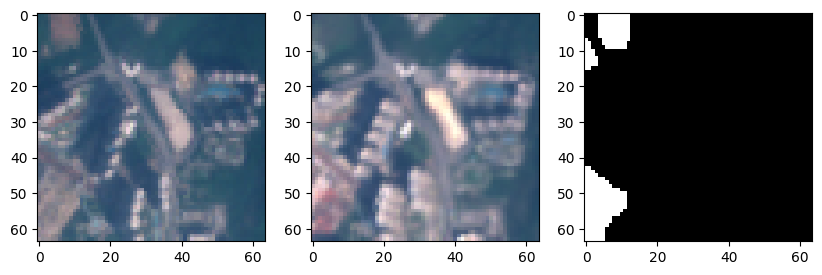

In [ ]:
def show_three(im1,im2,lab):
    fig,ax = plt.subplots(1,3,figsize=(10,10))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(lab[:,:,0], cmap='gray')

def show_four(im1,im2,lab,pred):
    fig,ax = plt.subplots(1,4,figsize=(10,10))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(lab[:,:,0], cmap='gray')
    ax[3].imshow(pred[:,:,0], cmap='gray')

def random_from_triplet(triplets):
    sample = np.random.randint(0,len(triplets[0]))
    print("#"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    #im1.shape,im2.shape,target.shape
    return im1,im2,lab

def show_rand_tripplet(triplets):
    im1,im2,lab = random_from_triplet(triplets)
    show_three(im1,im2,lab)
    print(np.min(lab), np.max(lab))

show_rand_tripplet(train_triplets)

Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
#910
0 1
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)
#391
0 1


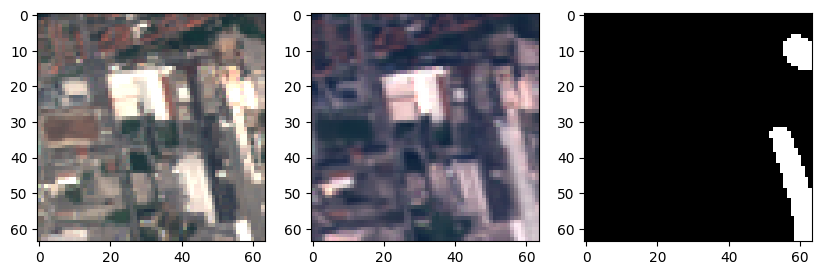

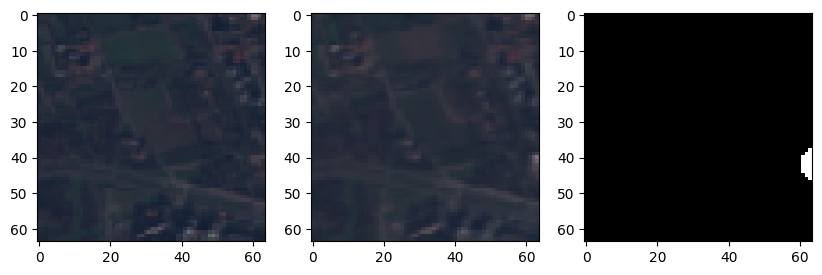

In [ ]:
# Train
print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
show_rand_tripplet(train_triplets)
#Test
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)
show_rand_tripplet(test_triplets)

In [ ]:
import segmentation_models as sm
#import keras
from tensorflow import keras

sm.set_framework('tf.keras') # for Collab ~
sm.framework()

keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [ ]:
# Dataset:
## train_triplets, test_triplets => x_train, y_train, x_val, y_val

# dummy approach pixel differencing at the input!

def keras_dataset_differencingPixels(triplets):
    # input triples
    # outputs x, y
    train_im1, train_im2, train_labels = triplets
    print("in", train_im1.shape, train_im2.shape, train_labels.shape)

    x = train_im1 - train_im2
    y = train_labels

    x = x.astype(np.float32)
    y = y.astype(np.float32)
    print("out", x.shape, y.shape, "types:", x.dtype, y.dtype)
    return x, y

x_train, y_train = keras_dataset_differencingPixels(train_triplets)
x_val, y_val = keras_dataset_differencingPixels(test_triplets)

in (1044, 64, 64, 3) (1044, 64, 64, 3) (1044, 64, 64, 1)
out (1044, 64, 64, 3) (1044, 64, 64, 1) types: float32 float32
in (663, 64, 64, 3) (663, 64, 64, 3) (663, 64, 64, 1)
out (663, 64, 64, 3) (663, 64, 64, 1) types: float32 float32


In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

model.summary()

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 39s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

model.save("model.keras")

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - auc: 0.7401 - iou_score: 0.1586 - loss: 1.3358 - val_auc: 0.4990 - val_iou_score: 0.0161 - val_loss: 2.1936
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - auc: 0.8859 - iou_score: 0.3180 - loss: 0.9104 - val_auc: 0.5139 - val_iou_score: 0.0189 - val_loss: 1.2296
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - auc: 0.9079 - iou_score: 0.3657 - loss: 0.8574 - val_auc: 0.4829 - val_iou_score: 0.0055 - val_loss: 1.2780
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - auc: 0.9439 - iou_score: 0.4789 - loss: 0.7020 - val_auc: 0.4861 - val_iou_score: 0.0045 - val_loss: 1.2839
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - auc: 0.9544 - iou_score: 0.5089 - loss: 0.6535 - val_auc: 0.4956 - val_iou_score: 0.0025 - val_loss: 1.6695
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - auc: 0.9600 - iou_score: 0.5677 - loss: 0.5823 - val_auc: 0.4990 - val_iou_score: 0.0142 - val_loss: 2.1214
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━

In [ ]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)

    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

#482
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction visualization


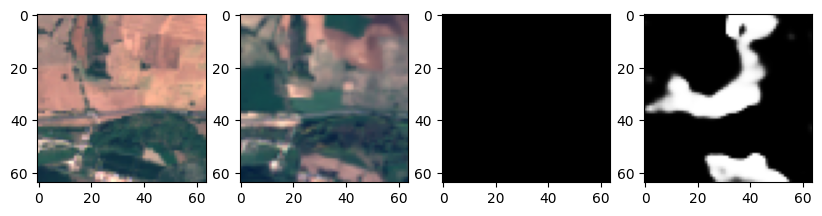

In [ ]:
# prompt: show_four(im1,im2,lab,y_pred) plot this

predict_with_model_rand(test_triplets)

In [ ]:
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)
model.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 73,333,764 (279.75 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

 Optimizer params: 48,877,610 (186.45 MB)

In [ ]:
h = history.history
print(history.history.keys())

dict_keys(['auc', 'iou_score', 'loss', 'val_auc', 'val_iou_score', 'val_loss'])


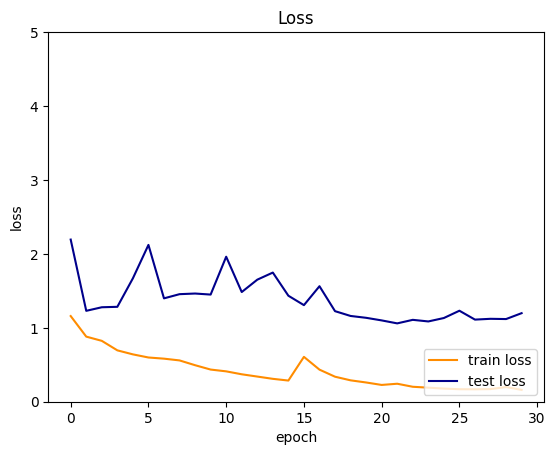

In [ ]:
plt.figure()
plt.plot(h['loss'], color='darkorange', label='train loss')
plt.plot(h['val_loss'], color='darkblue', label='test loss')
plt.ylim(0,5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_loss.png")
#plt.close()

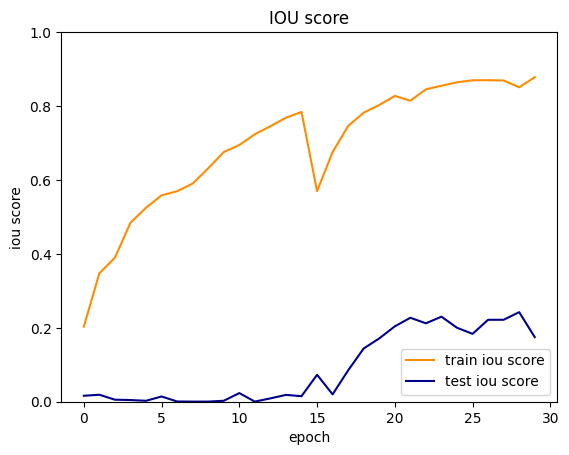

In [ ]:
plt.figure()
plt.plot(h['iou_score'], color='darkorange', label='train iou score')
plt.plot(h['val_iou_score'], color='darkblue', label='test iou score')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('iou score')
plt.title('IOU score')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_iou.png")
#plt.close()


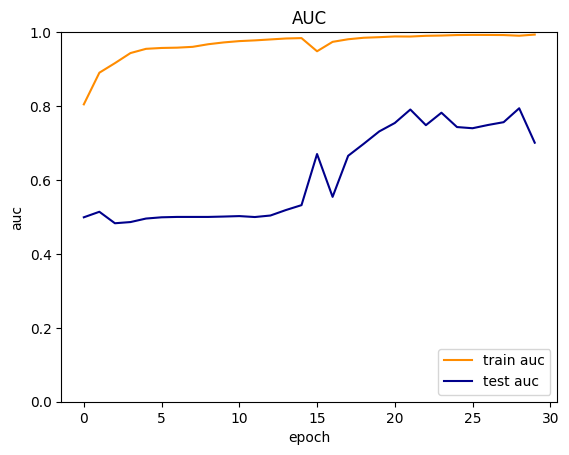

In [ ]:
plt.figure()
plt.plot(h['auc'], color='darkorange', label='train auc')
plt.plot(h['val_auc'], color='darkblue', label='test auc')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('auc')
plt.title('AUC')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist.png")
#plt.close()

#471
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Prediction visualization
#190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Prediction visualization
#585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Prediction visualization
#301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Prediction visualization


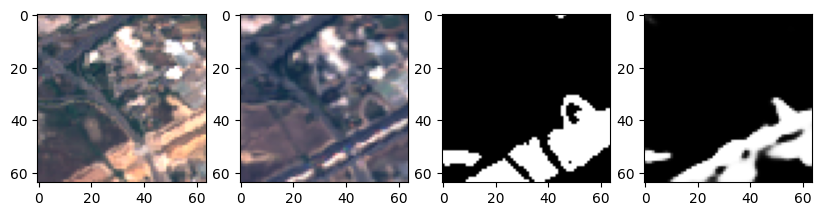

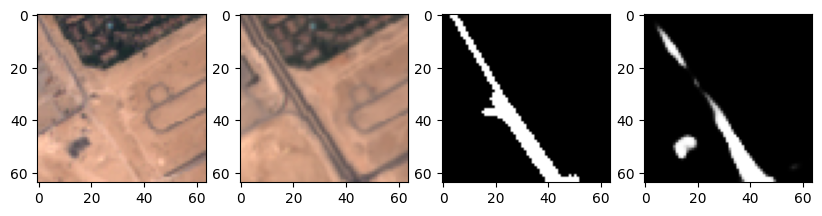

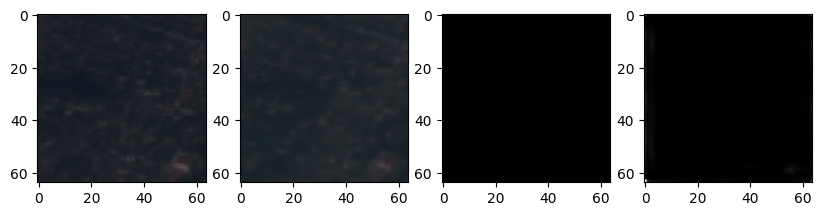

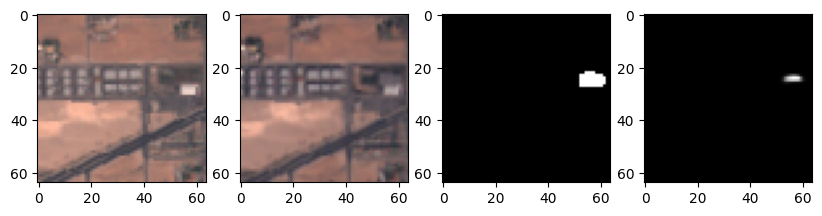

In [ ]:
for _ in range(4):
  predict_with_model_rand(test_triplets)
  #predict_with_model_rand(train_triplets)

In [ ]:
def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1

<>:53: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:53: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
C:\Users\user\AppData\Local\Temp\ipykernel_2936\3349716934.py:53: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if save_text_file is not "":


In [ ]:
def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets

    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)

    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 587ms/step


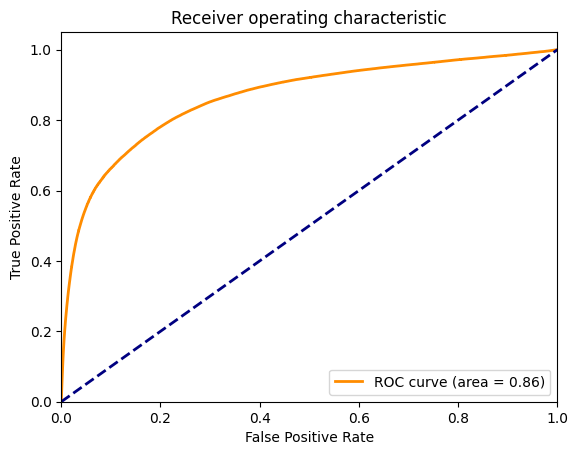

Finished with AUC (test set) = 0.8640949655059766
              precision    recall  f1-score   support

   no change       0.96      0.99      0.97   2569623
      change       0.58      0.27      0.37    146025

    accuracy                           0.95   2715648
   macro avg       0.77      0.63      0.67   2715648
weighted avg       0.94      0.95      0.94   2715648

[[2541209   28414]
 [ 106686   39339]]
saving to... test.txt
Recall 0.2693990755007704 Prec 0.5806237362183224 Acc 0.950251284407994 F1 0.368035999962578
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 508ms/step


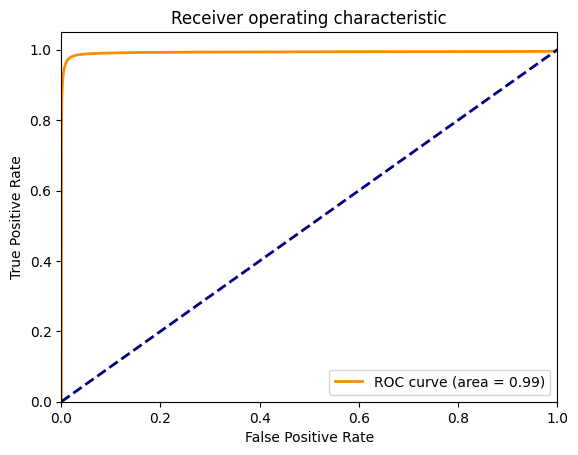

Finished with AUC (train set) = 0.9924409667263641
              precision    recall  f1-score   support

   no change       0.99      1.00      0.99   3826130
      change       0.98      0.90      0.94    450094

    accuracy                           0.99   4276224
   macro avg       0.98      0.95      0.97   4276224
weighted avg       0.99      0.99      0.99   4276224

[[3817462    8668]
 [  44849  405245]]
saving to... train.txt
Recall 0.9003563700027105 Prec 0.9790584011615968 Acc 0.9874849867546696 F1 0.9380595296102925


In [ ]:
predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)